In [1]:
import pandas as pd
import glob
import os

# Get all csv files in the folder
folder_path = 'Aligned Data All Participants'

# Initialize separate dictionaries
axial_rotation = {}
flexion = {}
lateral_bending = {}

# Get all CSV files
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

for file in all_files:
    try:
        # Get the filename without path or extension
        filename = os.path.splitext(os.path.basename(file))[0]
        
        # Read the CSV file
        df = pd.read_csv(file)

        # Add source column (IMU or MoCap)
        if 'IMU' in filename.upper():
            df['Device'] = 'IMU'
        elif 'MOCAP' in filename.upper():
            df['Device'] = 'MoCap'
        else:
            df['Device'] = 'Unknown'
            print(f"Warning: Couldn't determine source for {filename}")
        
        # Add filename as a column for reference
        df['Filename'] = filename 
        
        # Categorize based on filename
        if 'AxialRotation' in filename:
            axial_rotation[filename] = df
        elif 'Flexion' in filename:
            flexion[filename] = df
        elif 'LateralBending' in filename:
            lateral_bending[filename] = df
        else:
            print(f"File {filename} didn't match any category")
            
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")

print(f"Loaded {len(axial_rotation)} AxialRotation files")
print(f"Loaded {len(flexion)} Flexion files")
print(f"Loaded {len(lateral_bending)} LateralBending files")

Loaded 52 AxialRotation files
Loaded 56 Flexion files
Loaded 54 LateralBending files


In [2]:
import re

def parse_filename_components(df_dict):
    """Adds columns for trial number and time range extracted from filenames"""
    for name, df in df_dict.items():
        # Extract components using regular expression
        match = re.match(r'^(\d+)(.*?)_(IMU|MoCap)_(\d+s)_to_(\d+s)$', name)
        
        if match:
            # Add new columns
            df['TrialNumber'] = int(match.group(1))  # First number in filename
            df['TimeRange'] = f"{match.group(4)}-{match.group(5)}"  # Time range
            df['Duration'] = float(match.group(5).replace('s','')) - float(match.group(4).replace('s',''))
        else:
            print(f"Warning: Filename format not recognized for {name}")
            df['TrialNumber'] = None
            df['TimeRange'] = None
            df['Duration'] = None
    
    return df_dict

axial_rotation = parse_filename_components(axial_rotation)
flexion = parse_filename_components(flexion)
lateral_bending = parse_filename_components(lateral_bending)

In [ ]:
axial_rotation.get('10AxialRotation_IMU_95s_to_127s').head()

,Shifted Time (s),AxialRotation Angle IMU (degrees),Device,Filename,TrialNumber,TimeRange,Duration
0,95.001,7.925332,IMU,10AxialRotation_IMU_95s_to_127s,10,95s-127s,32.0
1,95.011,7.936056,IMU,10AxialRotation_IMU_95s_to_127s,10,95s-127s,32.0
2,95.021,7.944948,IMU,10AxialRotation_IMU_95s_to_127s,10,95s-127s,32.0
3,95.031,7.955058,IMU,10AxialRotation_IMU_95s_to_127s,10,95s-127s,32.0
4,95.040,7.962969,IMU,10AxialRotation_IMU_95s_to_127s,10,95s-127s,32.0


In [13]:
axial_rotation.get('10AxialRotation_MoCap_95s_to_127s').head()

,Time (s),AxialRotation Angle MoCap (degrees),Device,Filename,TrialNumber,TimeRange,Duration
0,95.003333,0.874382,MoCap,10AxialRotation_MoCap_95s_to_127s,10,95s-127s,32.0
1,95.010000,0.798631,MoCap,10AxialRotation_MoCap_95s_to_127s,10,95s-127s,32.0
2,95.016667,0.779130,MoCap,10AxialRotation_MoCap_95s_to_127s,10,95s-127s,32.0
3,95.023333,0.819145,MoCap,10AxialRotation_MoCap_95s_to_127s,10,95s-127s,32.0
4,95.030000,0.796051,MoCap,10AxialRotation_MoCap_95s_to_127s,10,95s-127s,32.0


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def plot_motion(motion: str, d: dict, all: bool = True, diff: bool = True, by_device: bool = True):
    if all:
        # Create figure 1 - All trials combined
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 1, 1)
        for name, df in d.items():
            plt.plot(df.iloc[:, 0], df.iloc[:, 1], label=name, alpha=0.7)
        plt.title(f"{motion} - All Trials")
        plt.ylabel('Value')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()

    if diff:
        # Create figure 2 - Difference between MoCap and IMU for each trial
        plt.figure(figsize=(15, 8))

        # Group data by trial number
        trials = sorted(set(df['TrialNumber'].iloc[0] for df in d.values()))

        # Create a colormap for different trials
        colors = plt.cm.viridis(np.linspace(0, 1, len(trials)))

        for trial, color in zip(trials, colors):
            # Get IMU and MoCap data for this trial
            imu_df = next((df for name, df in d.items() 
                        if df['TrialNumber'].iloc[0] == trial and df['Device'].iloc[0] == 'IMU'), None)
            mocap_df = next((df for name, df in d.items() 
                            if df['TrialNumber'].iloc[0] == trial and df['Device'].iloc[0] == 'MoCap'), None)

            if imu_df is not None and mocap_df is not None:
                # Resample or interpolate to match time points
                time_min = max(imu_df.iloc[0, 0], mocap_df.iloc[0, 0])
                time_max = min(imu_df.iloc[-1, 0], mocap_df.iloc[-1, 0])
                
                # Calculate difference
                common_time = np.linspace(time_min, time_max, 1000)
                imu_interp = np.interp(common_time, imu_df.iloc[:, 0], imu_df.iloc[:, 1])
                mocap_interp = np.interp(common_time, mocap_df.iloc[:, 0], mocap_df.iloc[:, 1])
                difference = mocap_interp - imu_interp
                
                plt.plot(common_time, difference, 
                        label=f'Trial {trial}', 
                        color=color,
                        alpha=0.7)

        plt.title(f"{motion} - MoCap vs IMU Differences (All Trials)")
        plt.xlabel('Time')
        plt.ylabel('Difference (MoCap - IMU)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if by_device:
        # Create figure 3 - Separate plots for IMU and MoCap
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 1, figure=fig)
        
        # IMU plot
        ax1 = fig.add_subplot(gs[0])
        for name, df in d.items():
            if df['Device'].iloc[0] == 'IMU':
                ax1.plot(df.iloc[:, 0], df.iloc[:, 1], label=f"Trial {df['TrialNumber'].iloc[0]}", alpha=0.7)
        ax1.set_title(f'{motion} - IMU')
        ax1.set_ylabel('Value')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        # MoCap plot
        ax2 = fig.add_subplot(gs[1])
        for name, df in d.items():
            if df['Device'].iloc[0] == 'MoCap':
                ax2.plot(df.iloc[:, 0], df.iloc[:, 1], label=f"Trial {df['TrialNumber'].iloc[0]}", alpha=0.7)
        ax2.set_title(f'{motion} - MoCap')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Value')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

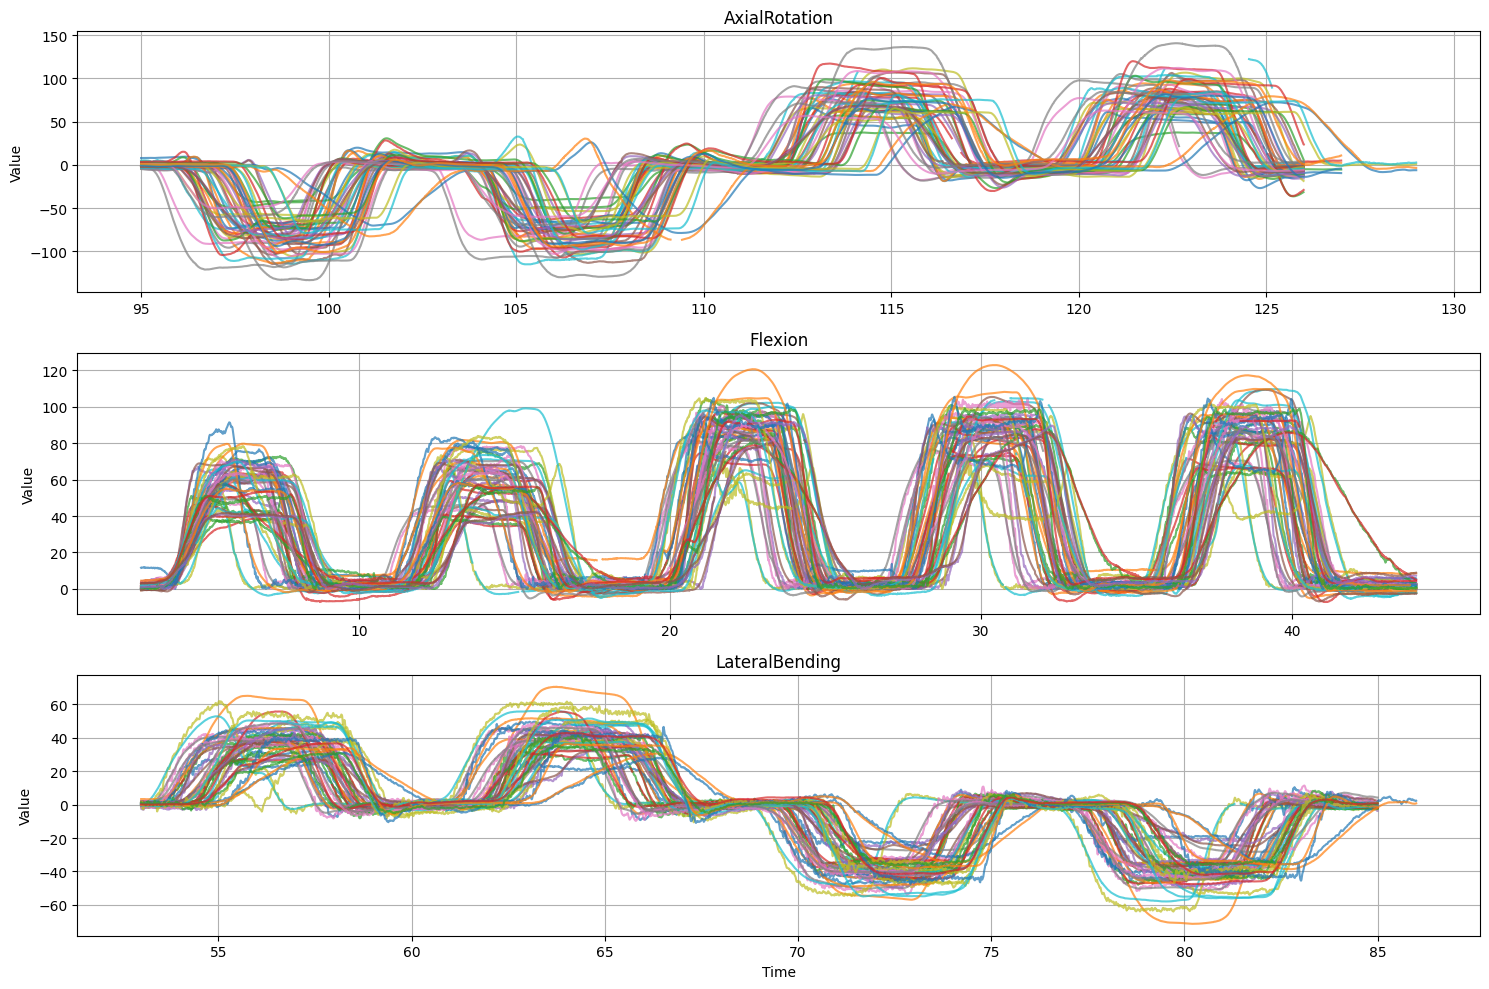

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the figure
plt.figure(figsize=(15, 10))

# 1. Plot AxialRotation files
plt.subplot(3, 1, 1)
for name, df in axial_rotation.items():
    plt.plot(df.iloc[:, 0], df.iloc[:, 1], label=name, alpha=0.7)
plt.title('AxialRotation')
plt.ylabel('Value')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 2. Plot Flexion files
plt.subplot(3, 1, 2)
for name, df in flexion.items():
    plt.plot(df.iloc[:, 0], df.iloc[:, 1], label=name, alpha=0.7)
plt.title('Flexion')
plt.ylabel('Value')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 3. Plot LateralBending files
plt.subplot(3, 1, 3)
for name, df in lateral_bending.items():
    plt.plot(df.iloc[:, 0], df.iloc[:, 1], label=name, alpha=0.7)
plt.title('LateralBending')
plt.xlabel('Time')
plt.ylabel('Value')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11592\2681005391.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


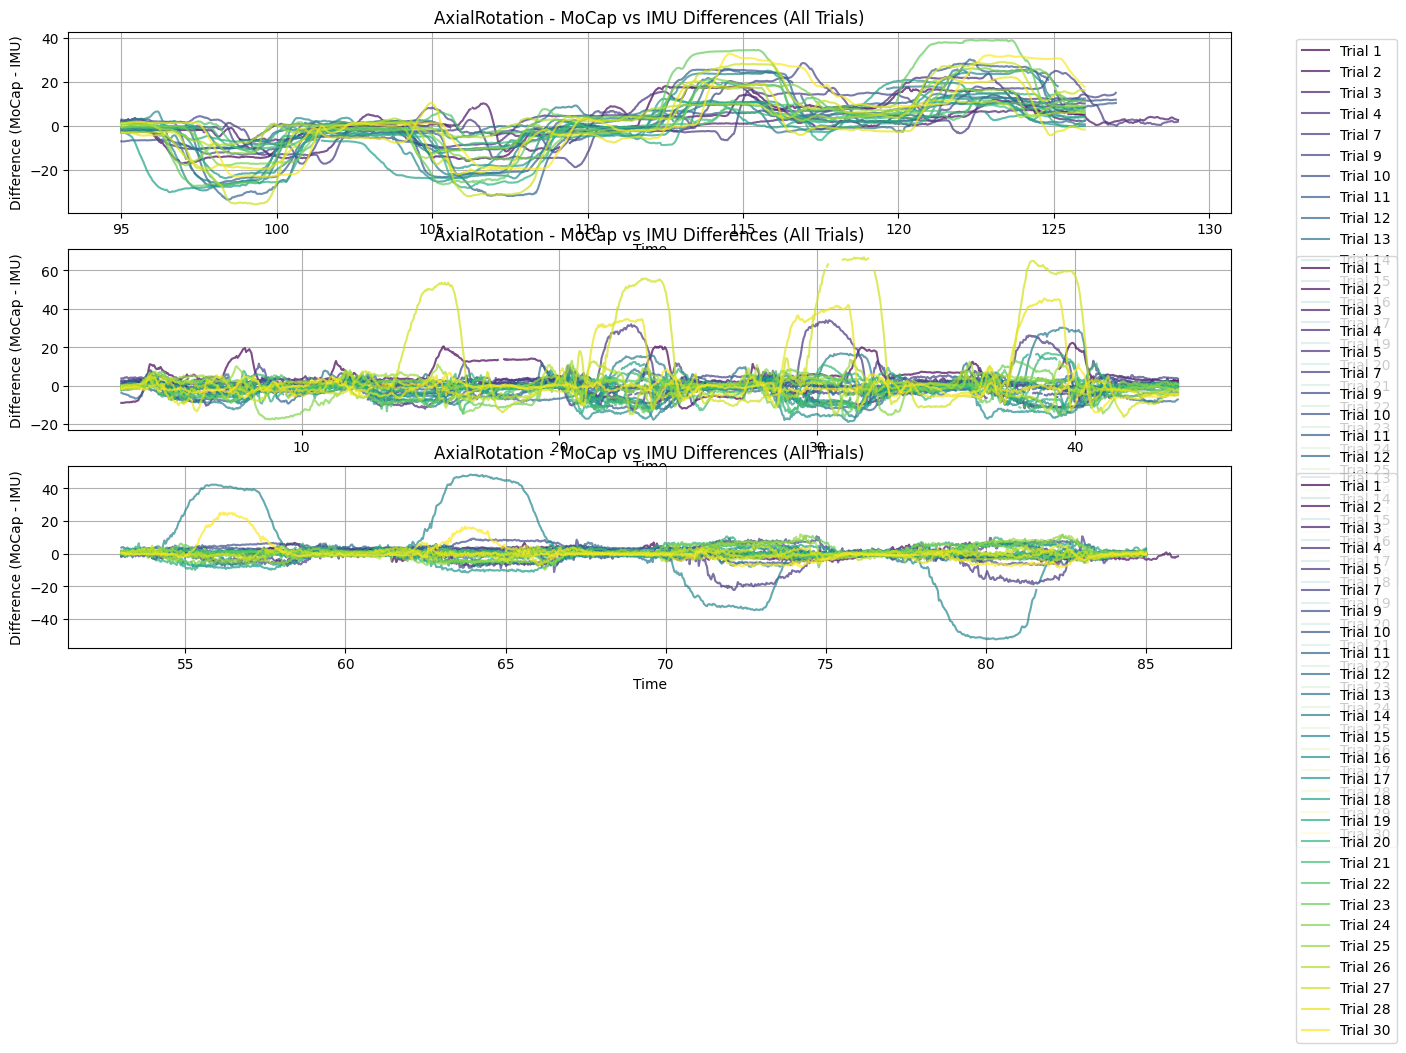

In [6]:
# Create figure 2 - Difference between MoCap and IMU for each trial
plt.figure(figsize=(15, 8))


plt.subplot(3, 1, 1)
# Group data by trial number
trials = sorted(set(df['TrialNumber'].iloc[0] for df in axial_rotation.values()))

# Create a colormap for different trials
colors = plt.cm.viridis(np.linspace(0, 1, len(trials)))

for trial, color in zip(trials, colors):
    # Get IMU and MoCap data for this trial
    imu_df = next((df for name, df in axial_rotation.items() 
                if df['TrialNumber'].iloc[0] == trial and df['Device'].iloc[0] == 'IMU'), None)
    mocap_df = next((df for name, df in axial_rotation.items() 
                    if df['TrialNumber'].iloc[0] == trial and df['Device'].iloc[0] == 'MoCap'), None)

    if imu_df is not None and mocap_df is not None:
        # Resample or interpolate to match time points
        time_min = max(imu_df.iloc[0, 0], mocap_df.iloc[0, 0])
        time_max = min(imu_df.iloc[-1, 0], mocap_df.iloc[-1, 0])
        
        # Calculate difference
        common_time = np.linspace(time_min, time_max, 1000)
        imu_interp = np.interp(common_time, imu_df.iloc[:, 0], imu_df.iloc[:, 1])
        mocap_interp = np.interp(common_time, mocap_df.iloc[:, 0], mocap_df.iloc[:, 1])
        difference = mocap_interp - imu_interp
        
        plt.plot(common_time, difference, 
                label=f'Trial {trial}', 
                color=color,
                alpha=0.7)

plt.title(f"{'AxialRotation'} - MoCap vs IMU Differences (All Trials)")
plt.xlabel('Time')
plt.ylabel('Difference (MoCap - IMU)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.subplot(3, 1, 2)
# Group data by trial number
trials = sorted(set(df['TrialNumber'].iloc[0] for df in flexion.values()))

# Create a colormap for different trials
colors = plt.cm.viridis(np.linspace(0, 1, len(trials)))

for trial, color in zip(trials, colors):
    # Get IMU and MoCap data for this trial
    imu_df = next((df for name, df in flexion.items() 
                if df['TrialNumber'].iloc[0] == trial and df['Device'].iloc[0] == 'IMU'), None)
    mocap_df = next((df for name, df in flexion.items() 
                    if df['TrialNumber'].iloc[0] == trial and df['Device'].iloc[0] == 'MoCap'), None)

    if imu_df is not None and mocap_df is not None:
        # Resample or interpolate to match time points
        time_min = max(imu_df.iloc[0, 0], mocap_df.iloc[0, 0])
        time_max = min(imu_df.iloc[-1, 0], mocap_df.iloc[-1, 0])
        
        # Calculate difference
        common_time = np.linspace(time_min, time_max, 1000)
        imu_interp = np.interp(common_time, imu_df.iloc[:, 0], imu_df.iloc[:, 1])
        mocap_interp = np.interp(common_time, mocap_df.iloc[:, 0], mocap_df.iloc[:, 1])
        difference = mocap_interp - imu_interp
        
        plt.plot(common_time, difference, 
                label=f'Trial {trial}', 
                color=color,
                alpha=0.7)

plt.title(f"{'AxialRotation'} - MoCap vs IMU Differences (All Trials)")
plt.xlabel('Time')
plt.ylabel('Difference (MoCap - IMU)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.subplot(3, 1, 3)
# Group data by trial number
trials = sorted(set(df['TrialNumber'].iloc[0] for df in lateral_bending.values()))

# Create a colormap for different trials
colors = plt.cm.viridis(np.linspace(0, 1, len(trials)))

for trial, color in zip(trials, colors):
    # Get IMU and MoCap data for this trial
    imu_df = next((df for name, df in lateral_bending.items() 
                if df['TrialNumber'].iloc[0] == trial and df['Device'].iloc[0] == 'IMU'), None)
    mocap_df = next((df for name, df in lateral_bending.items() 
                    if df['TrialNumber'].iloc[0] == trial and df['Device'].iloc[0] == 'MoCap'), None)

    if imu_df is not None and mocap_df is not None:
        # Resample or interpolate to match time points
        time_min = max(imu_df.iloc[0, 0], mocap_df.iloc[0, 0])
        time_max = min(imu_df.iloc[-1, 0], mocap_df.iloc[-1, 0])
        
        # Calculate difference
        common_time = np.linspace(time_min, time_max, 1000)
        imu_interp = np.interp(common_time, imu_df.iloc[:, 0], imu_df.iloc[:, 1])
        mocap_interp = np.interp(common_time, mocap_df.iloc[:, 0], mocap_df.iloc[:, 1])
        difference = mocap_interp - imu_interp
        
        plt.plot(common_time, difference, 
                label=f'Trial {trial}', 
                color=color,
                alpha=0.7)

plt.title(f"{'AxialRotation'} - MoCap vs IMU Differences (All Trials)")
plt.xlabel('Time')
plt.ylabel('Difference (MoCap - IMU)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

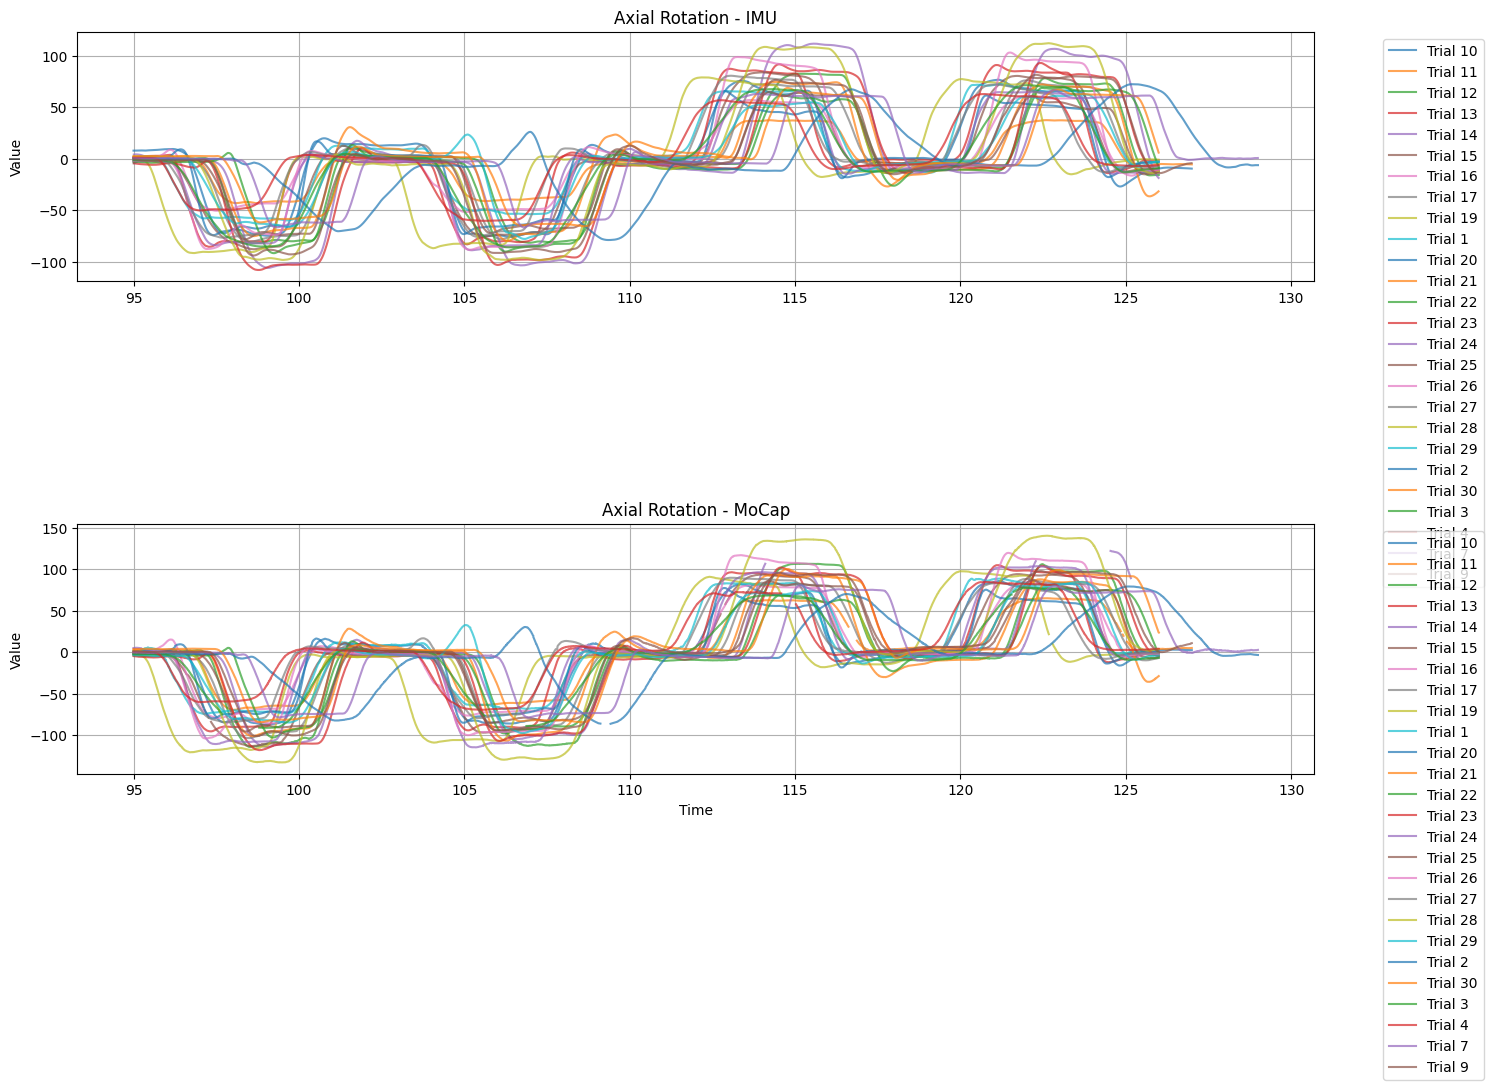

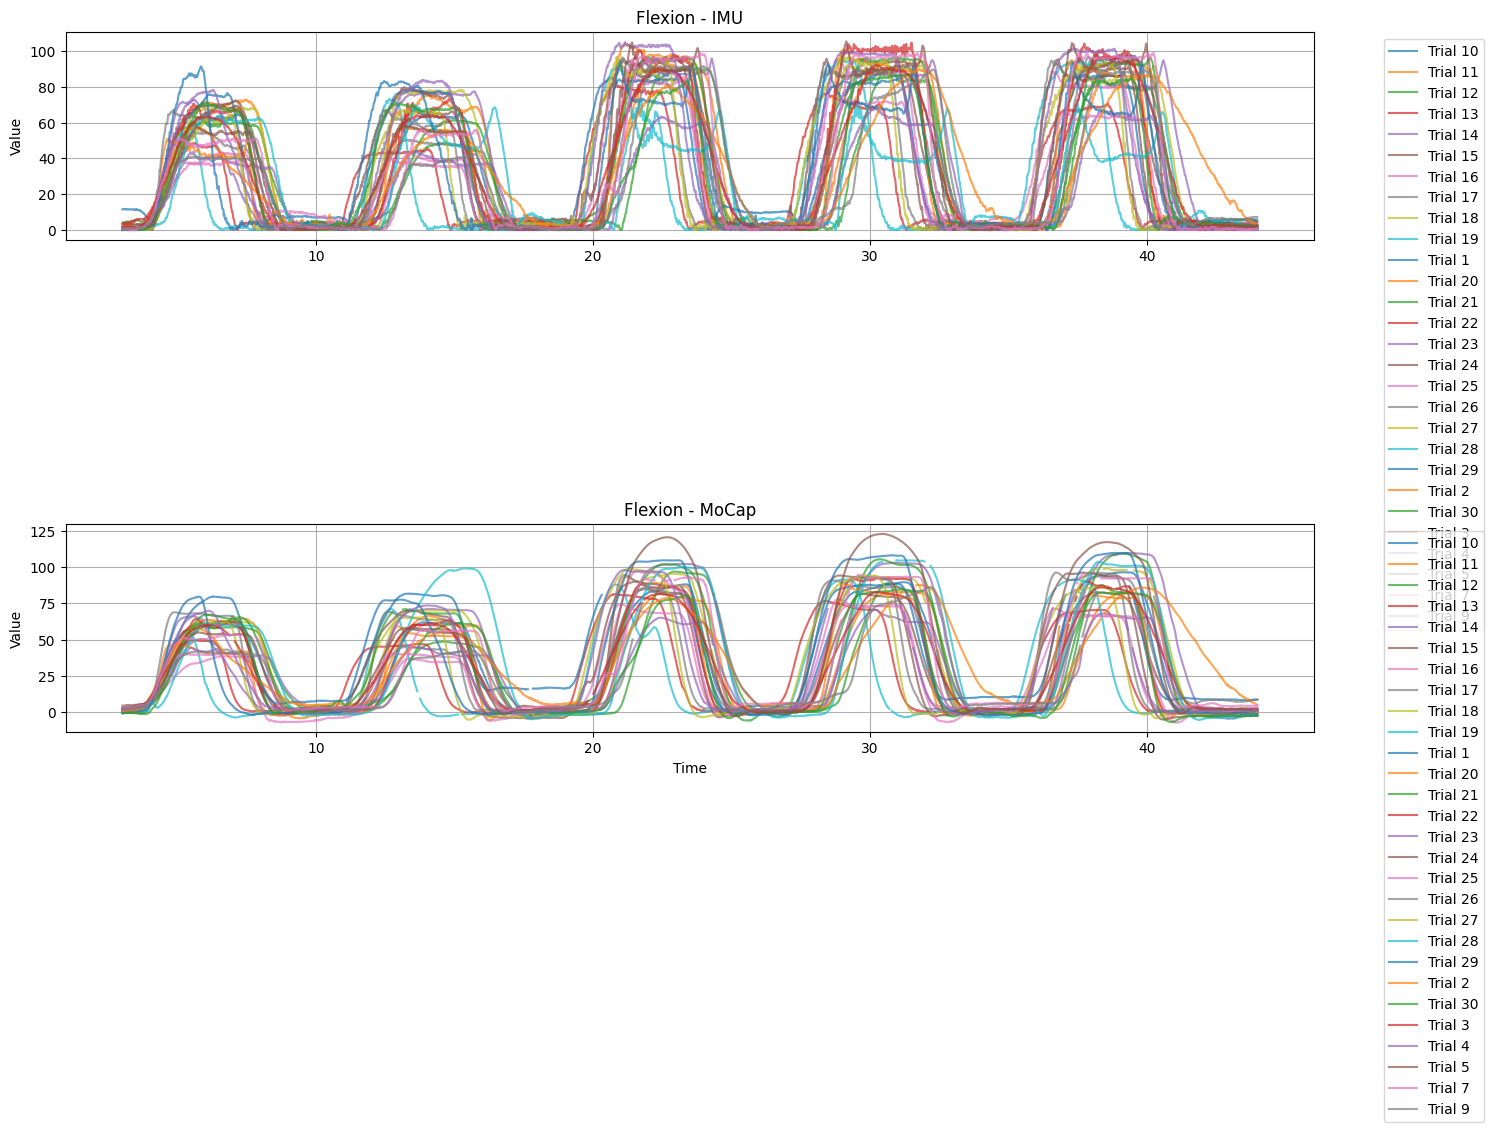

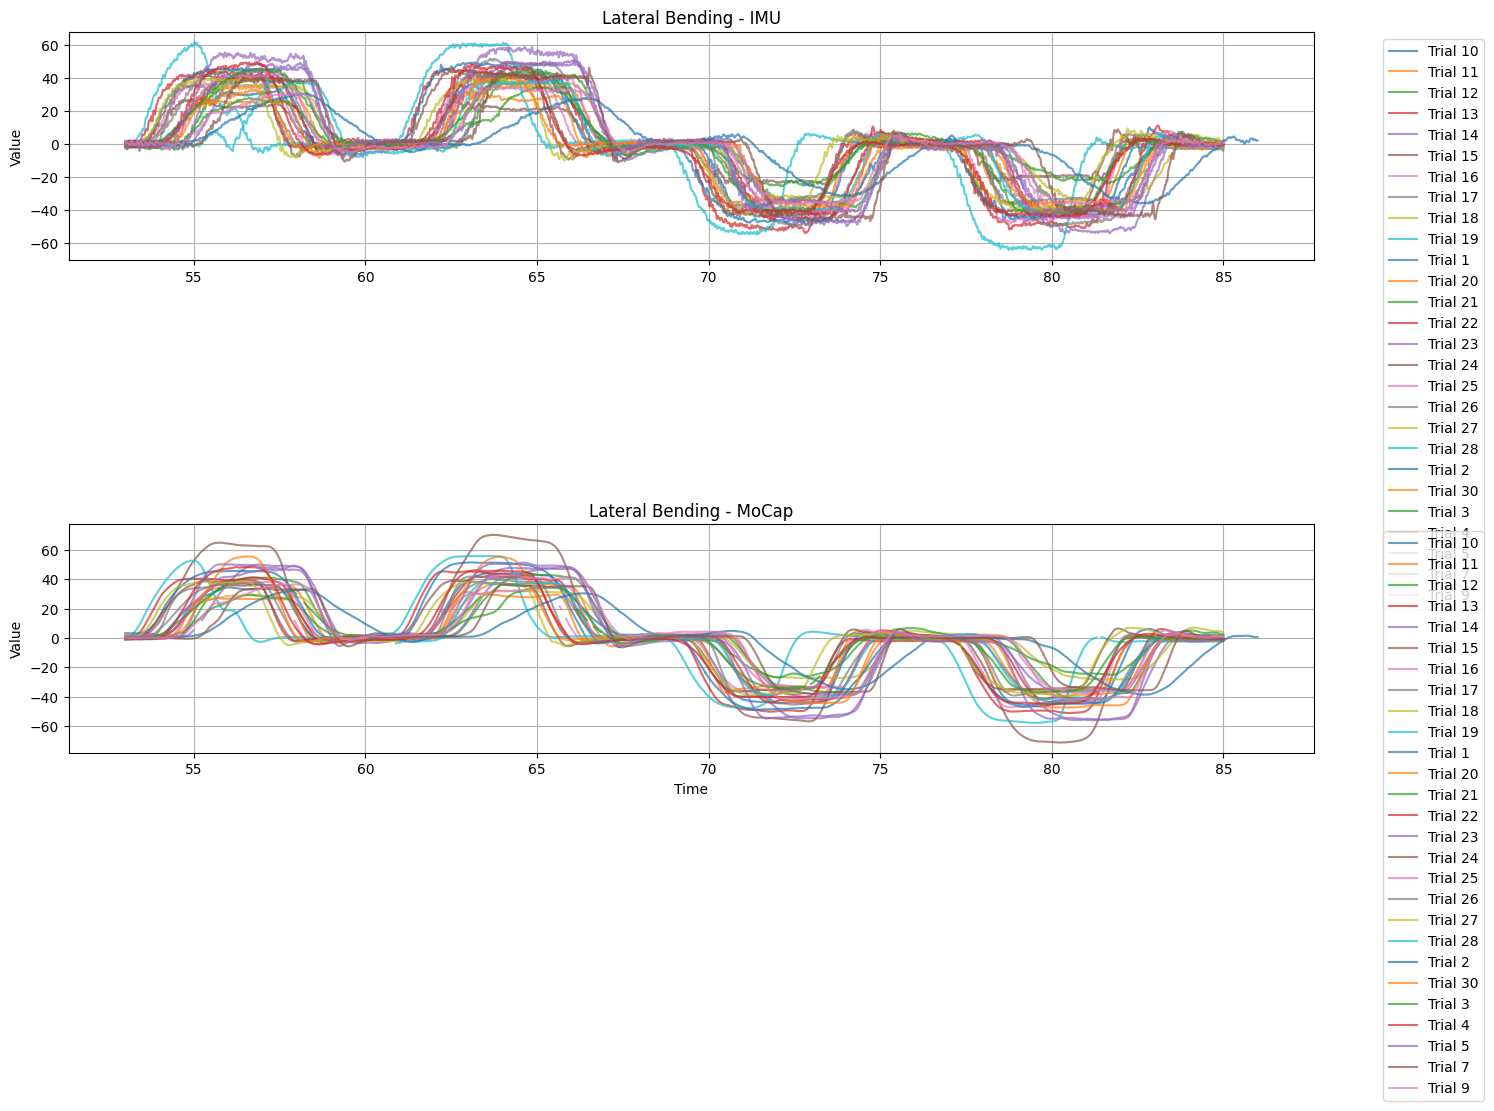

In [9]:
plot_motion('Axial Rotation', axial_rotation, False, False, True)
plot_motion('Flexion', flexion, False, False, True)
plot_motion('Lateral Bending', lateral_bending, False, False, True)